In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os

#카카오톡
dataset_filepath = os.getenv('HOME')+'/aiffel/stock_prediction/data/hynix000660.KS.csv' 

df = pd.read_csv(dataset_filepath, index_col='Date',parse_dates=True) 
ts1 = df['Close']

ts1=ts1.interpolate(method='time')
ts_log=np.log(ts1)

from statsmodels.tsa.stattools import adfuller

def augmented_dickey_fuller_test(timeseries):
    # statsmodels 패키지에서 제공하는 adfuller 메소드를 호출합니다.
    dftest = adfuller(timeseries, autolag='AIC')  
    
    # adfuller 메소드가 리턴한 결과를 정리하여 출력합니다.
    print('Results of Dickey-Fuller Test:')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)
    
    
def plot_rolling_statistics(timeseries, window=12):
    
    rolmean = timeseries.rolling(window=window).mean()  # 이동평균 시계열
    rolstd = timeseries.rolling(window=window).std()    # 이동표준편차 시계열

     # 원본시계열, 이동평균, 이동표준편차를 plot으로 시각화해 본다.
    orig = plt.plot(timeseries, color='blue',label='Original')    
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)

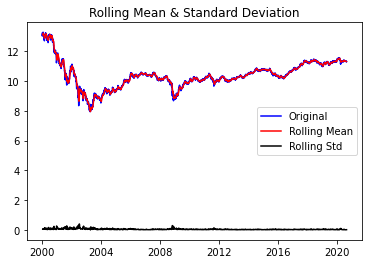

Results of Dickey-Fuller Test:
Test Statistic                   -2.963197
p-value                           0.038477
#Lags Used                        9.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


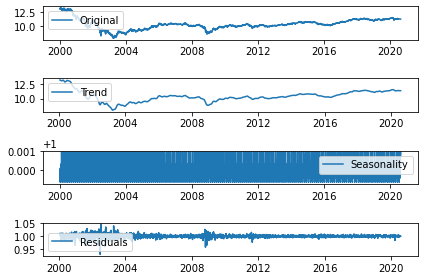

In [3]:
# 정성적 그래프 분석
plot_rolling_statistics(ts_log, window=12)

#정량적 Augmented Dicky-Fuller Test
augmented_dickey_fuller_test(ts_log)

#시계열 분해 (Time Series Decomposition)
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts_log, model='multiplicative', period = 30) 

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts_log, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(trend, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

In [4]:
residual.dropna(inplace=True)
augmented_dickey_fuller_test(residual)

Results of Dickey-Fuller Test:
Test Statistic                -1.731706e+01
p-value                        5.510111e-30
#Lags Used                     3.200000e+01
Number of Observations Used    5.124000e+03
Critical Value (1%)           -3.431627e+00
Critical Value (5%)           -2.862104e+00
Critical Value (10%)          -2.567070e+00
dtype: float64


In [5]:
train_data, test_data = ts_log[:int(len(ts_log)*0.9)],ts_log[int(len(ts_log)*0.9):]

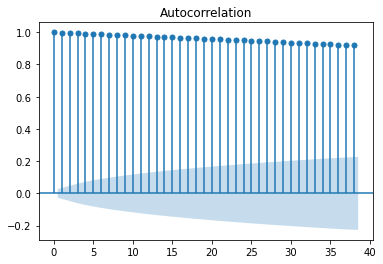

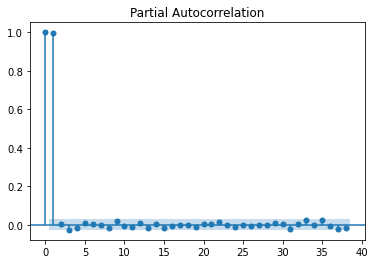

In [6]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

plot_acf(ts_log)   # ACF : Autocorrelation 그래프 그리기
plot_pacf(ts_log)  # PACF : Partial Autocorrelation 그래프 그리기
plt.show()

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Results of Dickey-Fuller Test:
Test Statistic                  -24.491136
p-value                           0.000000
#Lags Used                        8.000000
Number of Observations Used    5177.000000
Critical Value (1%)              -3.431614
Critical Value (5%)              -2.862098
Critical Value (10%)             -2.567067
dtype: float64


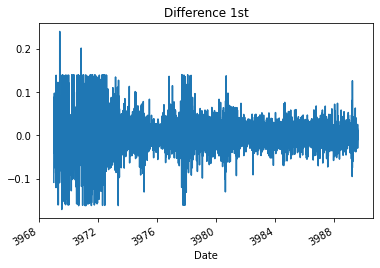

In [7]:
# d값 구하기
#1차 차분 구하기
diff_1 = ts_log.diff(periods=1).iloc[1:]
diff_1.plot(title='Difference 1st')

augmented_dickey_fuller_test(diff_1)

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/pandas/plotting/_matplotlib/converter.py:256: MatplotlibDeprecationWarning: 
The epoch2num function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
  base = dates.epoch2num(dt.asi8 / 1.0e9)


Results of Dickey-Fuller Test:
Test Statistic                  -21.296079
p-value                           0.000000
#Lags Used                       33.000000
Number of Observations Used    5151.000000
Critical Value (1%)              -3.431620
Critical Value (5%)              -2.862101
Critical Value (10%)             -2.567069
dtype: float64


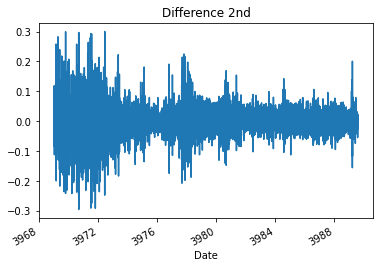

In [8]:
#2차 차분 구하기
diff_2 = diff_1.diff(periods=1).iloc[1:]
diff_2.plot(title='Difference 2nd')

augmented_dickey_fuller_test(diff_2)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

# Build Model
model = ARIMA(train_data, order=(1,1,0))  #p,d,q
fitted_m = model.fit(disp=-1)  
print(fitted_m.summary())

                             ARIMA Model Results                              
Dep. Variable:                D.Close   No. Observations:                 4667
Model:                 ARIMA(1, 1, 0)   Log Likelihood                8348.907
Method:                       css-mle   S.D. of innovations              0.040
Date:                Thu, 13 Aug 2020   AIC                         -16691.814
Time:                        16:16:51   BIC                         -16672.469
Sample:                             1   HQIC                        -16685.010
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const            -0.0004      0.001     -0.645      0.519      -0.002       0.001
ar.L1.D.Close     0.0369      0.015      2.518      0.012       0.008       0.066
                                    Root

/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/home/aiffel/anaconda3/envs/aiffel/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:218: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


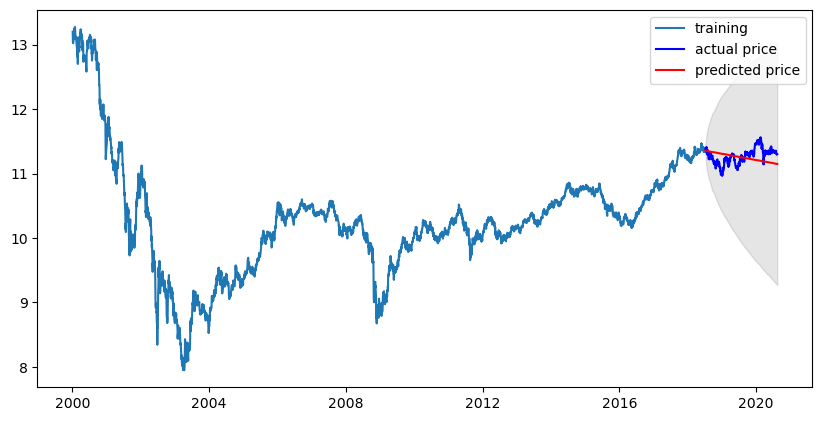

In [29]:
# Forecast : 결과가 fc에 담깁니다. 
fc, se, conf = fitted_m.forecast(len(test_data), alpha=0.05)  # 95% conf

# Make as pandas series
fc_series = pd.Series(fc, index=test_data.index)   # 예측결과
lower_series = pd.Series(conf[:, 0], index=test_data.index)  # 예측결과의 하한 바운드
upper_series = pd.Series(conf[:, 1], index=test_data.index)  # 예측결과의 상한 바운드

# Plot
plt.figure(figsize=(10,5), dpi=100)
plt.plot(train_data, label='training')
plt.plot(test_data, c='b', label='actual price')
plt.plot(fc_series, c='r',label='predicted price')
plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.10)
plt.legend()
plt.show()

In [30]:
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math

mse = mean_squared_error(np.exp(test_data), np.exp(fc))
print('MSE: ', mse)

mae = mean_absolute_error(np.exp(test_data), np.exp(fc))
print('MAE: ', mae)

rmse = math.sqrt(mean_squared_error(np.exp(test_data), np.exp(fc)))
print('RMSE: ', rmse)

mape = np.mean(np.abs(np.exp(fc) - np.exp(test_data))/np.abs(np.exp(test_data)))
print('MAPE: {:.2f}%'.format(mape*100))

MSE:  156497538.99091557
MAE:  10402.412652350697
RMSE:  12509.897641104646
MAPE: 13.18%
